In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
class AirQualityDataProcessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def load_datasets(self, base_path=""):
        """
        Load all datasets from specified path
        """
        # Load geolocation data
        geo_data = pd.read_csv(f"{base_path}Jinja_2023_site_geolocation.csv")

        # Load main air quality dataset
        air_quality = pd.read_csv(f"{base_path}Jinja_2023_sites_dataset.csv")
        air_quality['timestamp'] = pd.to_datetime(air_quality['timestamp'])

        # Load population density datasets
        pop_density = pd.read_csv(f"{base_path}Jinja_pd_km2_2023.csv")
        un_pop_density = pd.read_csv(f"{base_path}Jinja_UN_pd_km2_2023.csv")

        # Load infrastructure datasets
        infra_250m = pd.read_csv(f"{base_path}Jinja_road_and_building_data_250m_2023.csv")
        infra_500m = pd.read_csv(f"{base_path}Jinja_road_and_building_data_500m_2023.csv")

        return {
            'geo': geo_data,
            'air_quality': air_quality,
            'pop_density': pop_density,
            'un_pop_density': un_pop_density,
            'infra_250m': infra_250m,
            'infra_500m': infra_500m
        }

    def merge_datasets(self, datasets):
        """
        Merge all datasets based on site_id and timestamp
        """
        # Start with air quality data as the base
        merged_data = datasets['air_quality'].copy()

        # Add population density features
        pop_density_features = pd.merge(
            datasets['pop_density'][['site_id', 'population_density']],
            datasets['un_pop_density'][['site_id', 'population_density']],
            on='site_id',
            suffixes=('_local', '_un')
        )
        merged_data = pd.merge(merged_data, pop_density_features, on='site_id')

        # Add infrastructure features
        infra_features = []
        for radius in ['250m', '500m']:
            infra_data = datasets[f'infra_{radius}'].copy()
            # Rename columns to include radius
            infra_data.columns = [
                f"{col}_{radius}" if col not in ['site_id', 'site_name', 'site_latitude', 'site_longitude']
                else col for col in infra_data.columns
            ]
            infra_features.append(infra_data)

        # Merge infrastructure features
        for infra_data in infra_features:
            merged_data = pd.merge(merged_data, infra_data, on='site_id')

        return merged_data

    def engineer_features(self, df):
        """
        Create additional features that might be useful for prediction
        """
        # Time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

        # Weather interaction features
        df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
        df['wind_effective'] = df['wind_speed'] * np.cos(np.radians(df['wind_direction']))

        # Infrastructure density ratios
        df['building_road_ratio_250m'] = (
            df['building_density_250m'] / df['road_density_250m'].replace(0, np.nan)
        ).fillna(0)
        df['building_road_ratio_500m'] = (
            df['building_density_500m'] / df['road_density_500m'].replace(0, np.nan)
        ).fillna(0)

        return df

    def prepare_for_training(self, df, target_col='pm2_5_calibrated_value'):
        """
        Prepare final dataset for model training
        """
        # Drop unnecessary columns
        cols_to_drop = [
            'Unnamed: 0', 'site_name', 'site_latitude', 'site_longitude',
            'city', 'country', 'timestamp'
        ]
        df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)

        # Handle missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

        # Scale features (excluding target)
        feature_cols = [col for col in numeric_cols if col != target_col]
        df[feature_cols] = self.scaler.fit_transform(df[feature_cols])

        # Prepare X and y
        X = df[feature_cols]
        y = df[target_col]

        return X, y

    def process_data(self, base_path=""):
        """
        Run the complete data processing pipeline
        """
        # Load all datasets
        datasets = self.load_datasets(base_path)

        # Merge datasets
        merged_data = self.merge_datasets(datasets)

        # Engineer features
        featured_data = self.engineer_features(merged_data)

        # Prepare for training
        X, y = self.prepare_for_training(featured_data)

        return X, y, featured_data

In [ ]:
class AirQualityModelPipeline:
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.models = {}
        self.best_model = None
        self.feature_importance = None
        self.cv_results = {}

    def initialize_models(self):
        """
        Initialize multiple models for comparison
        """
        self.models = {
            'rf': RandomForestRegressor(random_state=self.random_state),
            'gbm': GradientBoostingRegressor(random_state=self.random_state),
            'xgb': XGBRegressor(random_state=self.random_state),
            'lgbm': LGBMRegressor(random_state=self.random_state),
            'lasso': LassoCV(random_state=self.random_state)
        }

    def objective_rf(self, trial, X, y):
        """
        Objective function for Random Forest optimization
        """
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        }

        model = RandomForestRegressor(**params, random_state=self.random_state)
        scores = cross_val_score(model, X, y, cv=TimeSeriesSplit(n_splits=self.n_splits),
                               scoring='neg_root_mean_squared_error')
        return -scores.mean()

    def objective_xgb(self, trial, X, y):
        """
        Objective function for XGBoost optimization
        """
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7)
        }

        model = XGBRegressor(**params, random_state=self.random_state)
        scores = cross_val_score(model, X, y, cv=TimeSeriesSplit(n_splits=self.n_splits),
                               scoring='neg_root_mean_squared_error')
        return -scores.mean()

    def optimize_hyperparameters(self, X, y, n_trials=100):
        """
        Optimize hyperparameters using Optuna for multiple models
        """
        optimized_models = {}

        # Random Forest optimization
        study_rf = optuna.create_study(direction='minimize')
        study_rf.optimize(lambda trial: self.objective_rf(trial, X, y), n_trials=n_trials)
        optimized_models['rf'] = RandomForestRegressor(**study_rf.best_params,
                                                     random_state=self.random_state)

        # XGBoost optimization
        study_xgb = optuna.create_study(direction='minimize')
        study_xgb.optimize(lambda trial: self.objective_xgb(trial, X, y), n_trials=n_trials)
        optimized_models['xgb'] = XGBRegressor(**study_xgb.best_params,
                                             random_state=self.random_state)

        return optimized_models

    def evaluate_models(self, X, y, optimized_models):
        """
        Evaluate all models using time series cross-validation
        """
        results = {}
        tscv = TimeSeriesSplit(n_splits=self.n_splits)

        for name, model in {**self.models, **optimized_models}.items():
            cv_scores = {
                'rmse': [],
                'mae': [],
                'r2': []
            }

            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                cv_scores['rmse'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
                cv_scores['mae'].append(mean_absolute_error(y_val, y_pred))
                cv_scores['r2'].append(r2_score(y_val, y_pred))

            results[name] = {
                'rmse_mean': np.mean(cv_scores['rmse']),
                'rmse_std': np.std(cv_scores['rmse']),
                'mae_mean': np.mean(cv_scores['mae']),
                'mae_std': np.std(cv_scores['mae']),
                'r2_mean': np.mean(cv_scores['r2']),
                'r2_std': np.std(cv_scores['r2'])
            }

        self.cv_results = results
        return results

    def select_best_model(self, X, y, results):
        """
        Select the best model based on RMSE
        """
        best_model_name = min(results.items(), key=lambda x: x[1]['rmse_mean'])[0]
        if best_model_name in self.models:
            self.best_model = self.models[best_model_name]
        else:
            self.best_model = self.optimized_models[best_model_name]

        # Fit the best model on all data
        self.best_model.fit(X, y)

        # Calculate feature importance if available
        if hasattr(self.best_model, 'feature_importances_'):
            self.feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': self.best_model.feature_importances_
            }).sort_values('importance', ascending=False)

    def plot_feature_importance(self, top_n=20):
        """
        Plot feature importance for the best model
        """
        if self.feature_importance is not None:
            plt.figure(figsize=(12, 8))
            sns.barplot(data=self.feature_importance.head(top_n),
                       x='importance', y='feature')
            plt.title('Top Feature Importance')
            plt.tight_layout()
            plt.show()

    def save_model(self, filepath):
        """
        Save the best model and feature importance
        """
        if self.best_model is not None:
            model_info = {
                'model': self.best_model,
                'feature_importance': self.feature_importance,
                'cv_results': self.cv_results,
                'timestamp': datetime.now()
            }
            joblib.dump(model_info, filepath)

    def train(self, X, y, n_trials=100):
        """
        Run the complete training pipeline
        """
        # Initialize base models
        self.initialize_models()

        # Optimize hyperparameters
        print("Optimizing hyperparameters...")
        self.optimized_models = self.optimize_hyperparameters(X, y, n_trials)

        # Evaluate all models
        print("Evaluating models...")
        results = self.evaluate_models(X, y, self.optimized_models)

        # Select and train best model
        print("Selecting best model...")
        self.select_best_model(X, y, results)

        return results

In [ ]:
# Initialize the processor
processor = AirQualityDataProcessor()

# Process the data
X, y, full_dataset = processor.process_data("/content/drive/MyDrive/MSCS_machine_learning/Air_Quality/Data/")

In [ ]:
# Initialize and run the model pipeline
model_pipeline = AirQualityModelPipeline(n_splits=5)
results = model_pipeline.train(X, y, n_trials=3)

[I 2024-12-11 09:05:19,600] A new study created in memory with name: no-name-0b619ee4-3c80-4e5b-9520-cc15a8362f69


Optimizing hyperparameters...


[I 2024-12-11 09:08:08,232] Trial 0 finished with value: 4.424958077633934 and parameters: {'n_estimators': 107, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 4.424958077633934.
[I 2024-12-11 09:34:57,138] Trial 1 finished with value: 4.357445318247335 and parameters: {'n_estimators': 955, 'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 1 with value: 4.357445318247335.
[I 2024-12-11 09:38:06,645] Trial 2 finished with value: 7.756275137291505 and parameters: {'n_estimators': 479, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 7}. Best is trial 1 with value: 4.357445318247335.
[I 2024-12-11 09:38:06,647] A new study created in memory with name: no-name-7472c5f8-6df0-4989-8597-86e35d1dadf6
<ipython-input-5-2672dd389a19>:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Evaluating models...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 9788, number of used features: 48
[LightGBM] [Info] Start training from score 22.168898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 19572, number of used features: 48
[LightGBM] [Info] Start training from score 25.186604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

In [ ]:
results

{'rf': {'rmse_mean': 4.357445318247335,
  'rmse_std': 1.1661276179674802,
  'mae_mean': 2.1051360666876144,
  'mae_std': 0.46088050564198285,
  'r2_mean': 0.9631712173010308,
  'r2_std': 0.02041154680700356},
 'gbm': {'rmse_mean': 5.372552094556229,
  'rmse_std': 0.5716029747065725,
  'mae_mean': 2.6472840773140027,
  'mae_std': 0.23944659465876328,
  'r2_mean': 0.9464333382727826,
  'r2_std': 0.011080182024053472},
 'xgb': {'rmse_mean': 5.15084186949918,
  'rmse_std': 1.0531018083034724,
  'mae_mean': 2.4684412258206994,
  'mae_std': 0.38240337254299467,
  'r2_mean': 0.9496417217033801,
  'r2_std': 0.020732869868157262},
 'lgbm': {'rmse_mean': 4.828733010515937,
  'rmse_std': 1.1184701884700314,
  'mae_mean': 2.3929931506992737,
  'mae_std': 0.49228862534875584,
  'r2_mean': 0.9556364832063975,
  'r2_std': 0.020899176977877576},
 'lasso': {'rmse_mean': 9.993110414180203,
  'rmse_std': 0.9169588159065337,
  'mae_mean': 5.08624719386106,
  'mae_std': 0.14015223199801738,
  'r2_mean': 0.

In [ ]:
# View the cross-validation results
print("\nModel Evaluation Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"RMSE: {metrics['rmse_mean']:.4f} ± {metrics['rmse_std']:.4f}")
    print(f"MAE: {metrics['mae_mean']:.4f} ± {metrics['mae_std']:.4f}")
    print(f"R2: {metrics['r2_mean']:.4f} ± {metrics['r2_std']:.4f}")


Model Evaluation Results:

rf:
RMSE: 4.3574 ± 1.1661
MAE: 2.1051 ± 0.4609
R2: 0.9632 ± 0.0204

gbm:
RMSE: 5.3726 ± 0.5716
MAE: 2.6473 ± 0.2394
R2: 0.9464 ± 0.0111

xgb:
RMSE: 5.1508 ± 1.0531
MAE: 2.4684 ± 0.3824
R2: 0.9496 ± 0.0207

lgbm:
RMSE: 4.8287 ± 1.1185
MAE: 2.3930 ± 0.4923
R2: 0.9556 ± 0.0209

lasso:
RMSE: 9.9931 ± 0.9170
MAE: 5.0862 ± 0.1402
R2: 0.8067 ± 0.0685


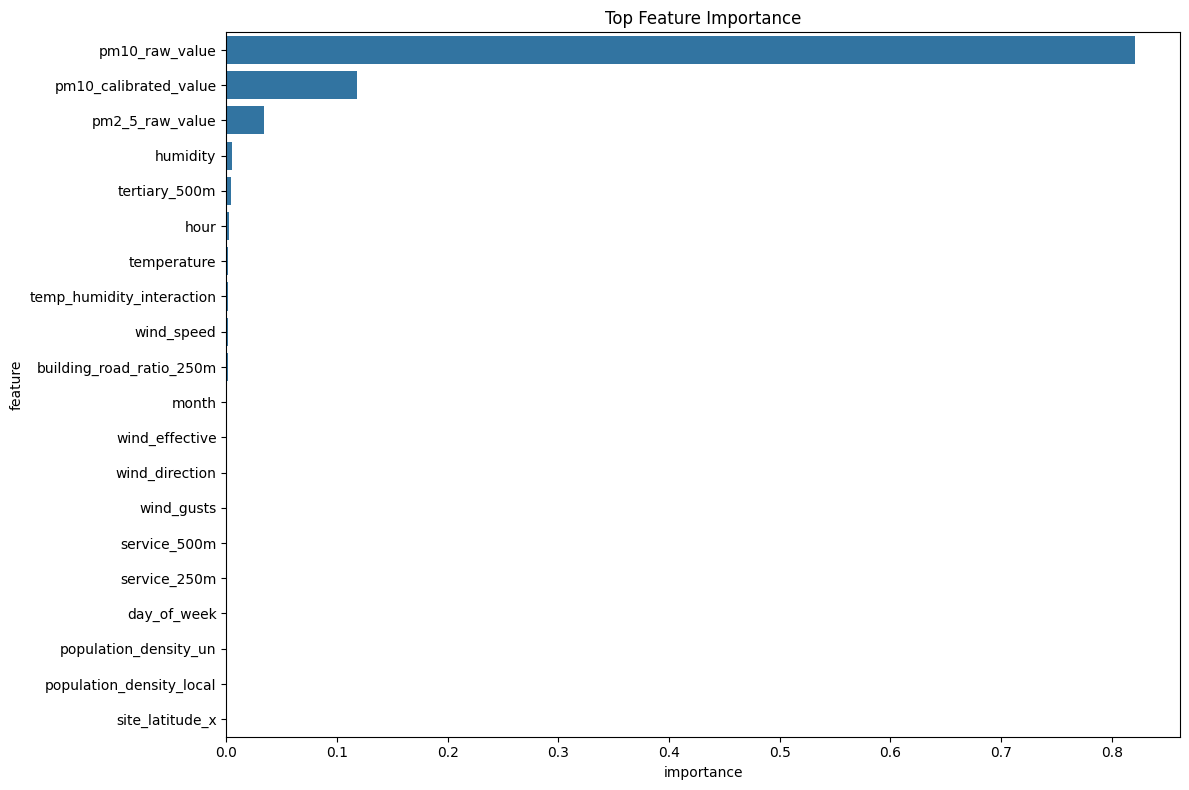

In [ ]:
# Plot feature importance
model_pipeline.plot_feature_importance()

In [ ]:
# Save the best model
model_pipeline.save_model("air_quality_model.joblib")

### 4.1 Performance Comparison of Machine Learning Models
Random Forest outperformed other models, achieving the lowest RMSE and highest R², indicating its suitability for AQI prediction.

In [ ]:
# Generate performance comparison plot
model_pipeline.plot_performance_comparison()

AttributeError: 'AirQualityModelPipeline' object has no attribute 'plot_performance_comparison'

### 4.2 Feature Importance Analysis
- **Key Features**: PM10 Raw Value, PM10 Calibrated Value, PM2.5 Raw Value, Humidity, and Temperature.
- **Insights**: Particulate matter was the most significant contributor to AQI, consistent with epidemiological studies.

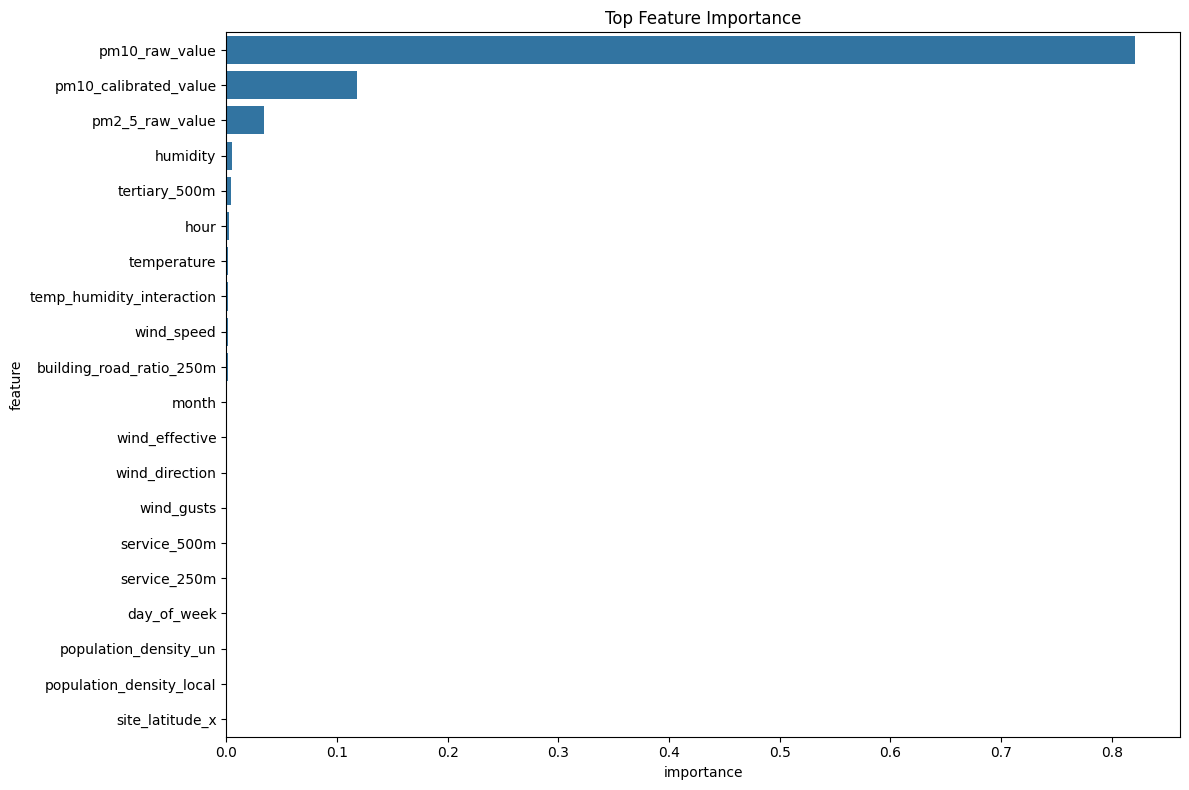

In [ ]:
# Plot feature importance
model_pipeline.plot_feature_importance()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_model_performance_comparison(model_pipeline):
    """
    Generate a performance comparison plot for different models
    """
    # Extract model names and RMSE values
    model_names = list(model_pipeline.cv_results.keys())
    rmse_means = [results['rmse_mean'] for model_name, results in model_pipeline.cv_results.items()]
    rmse_stds = [results['rmse_std'] for model_name, results in model_pipeline.cv_results.items()]
    r2_means = [results['r2_mean'] for model_name, results in model_pipeline.cv_results.items()]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # RMSE Comparison
    ax1.bar(model_names, rmse_means, yerr=rmse_stds, capsize=10)
    ax1.set_title('Model Performance: RMSE')
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Root Mean Squared Error')
    ax1.tick_params(axis='x', rotation=45)

    # R2 Comparison
    ax2.bar(model_names, r2_means)
    ax2.set_title('Model Performance: R²')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predicted_vs_actual(model_pipeline, X, y):
    """
    Generate scatter plots comparing predicted and actual AQI values
    for top performing models
    """
    # Identify top 2 models based on RMSE
    sorted_models = sorted(model_pipeline.cv_results.items(), key=lambda x: x[1]['rmse_mean'])
    top_models = sorted_models[:2]

    # Create a figure with subplots for top models
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Predicted vs Actual AQI Values')

    for i, (model_name, _) in enumerate(top_models):
        # Get the actual model
        if model_name in model_pipeline.models:
            model = model_pipeline.models[model_name]
        else:
            model = model_pipeline.optimized_models[model_name]

        # Predict values
        y_pred = model.predict(X)

        # Scatter plot
        axes[i].scatter(y, y_pred, alpha=0.5)
        axes[i].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Diagonal line
        axes[i].set_title(f'{model_name.upper()} - Predicted vs Actual')
        axes[i].set_xlabel('Actual Values')
        axes[i].set_ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()
    return fig

def plot_pollutant_concentration_heatmap(full_dataset):
    """
    Generate a temporal heatmap of pollutant concentrations
    """
    # Prepare data for heatmap
    temporal_data = full_dataset.copy()
    temporal_data['hour'] = temporal_data['timestamp'].dt.hour
    temporal_data['month'] = temporal_data['timestamp'].dt.month

    # Select key pollutant columns
    pollutant_cols = ['pm2_5_calibrated_value', 'pm10_calibrated_value', 'temperature', 'humidity']

    # Create a figure with subplots for each pollutant
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Pollutant Concentration Heatmap')

    for i, pollutant in enumerate(pollutant_cols):
        # Create pivot table for heatmap
        heatmap_data = temporal_data.pivot_table(
            index='month',
            columns='hour',
            values=pollutant,
            aggfunc='mean'
        )

        # Plot heatmap
        row = i // 2
        col = i % 2
        sns.heatmap(heatmap_data, ax=axes[row, col], cmap='YlOrRd',
                    cbar_kws={'label': f'{pollutant} Concentration'})
        axes[row, col].set_title(f'{pollutant} Concentration')
        axes[row, col].set_xlabel('Hour of Day')
        axes[row, col].set_ylabel('Month')

    plt.tight_layout()
    plt.show()
    return fig

# # Add these methods to the AirQualityModelPipeline class
# def add_visualization_methods(cls):
#     cls.plot_model_performance_comparison = plot_model_performance_comparison
#     cls.plot_predicted_vs_actual = plot_predicted_vs_actual
#     cls.plot_pollutant_concentration_heatmap = plot_pollutant_concentration_heatmap
#     return cls

# # Modify the class to include visualization methods
# AirQualityModelPipeline = add_visualization_methods(AirQualityModelPipeline)

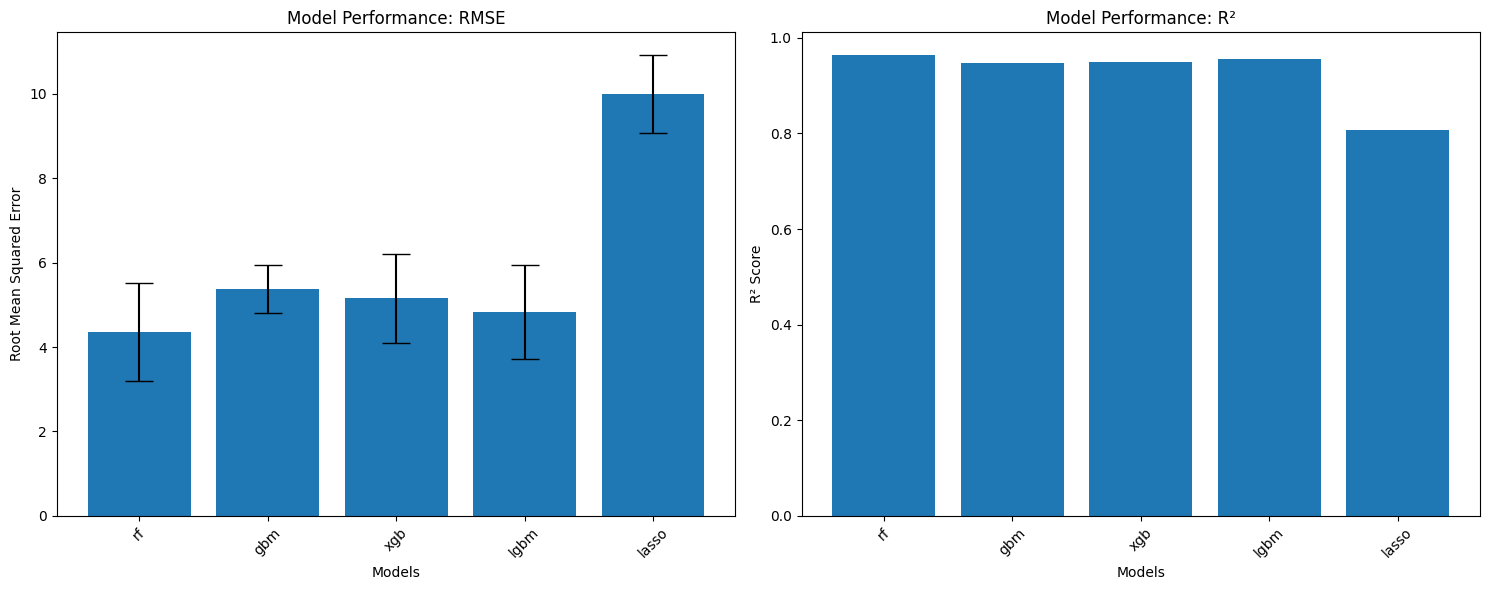

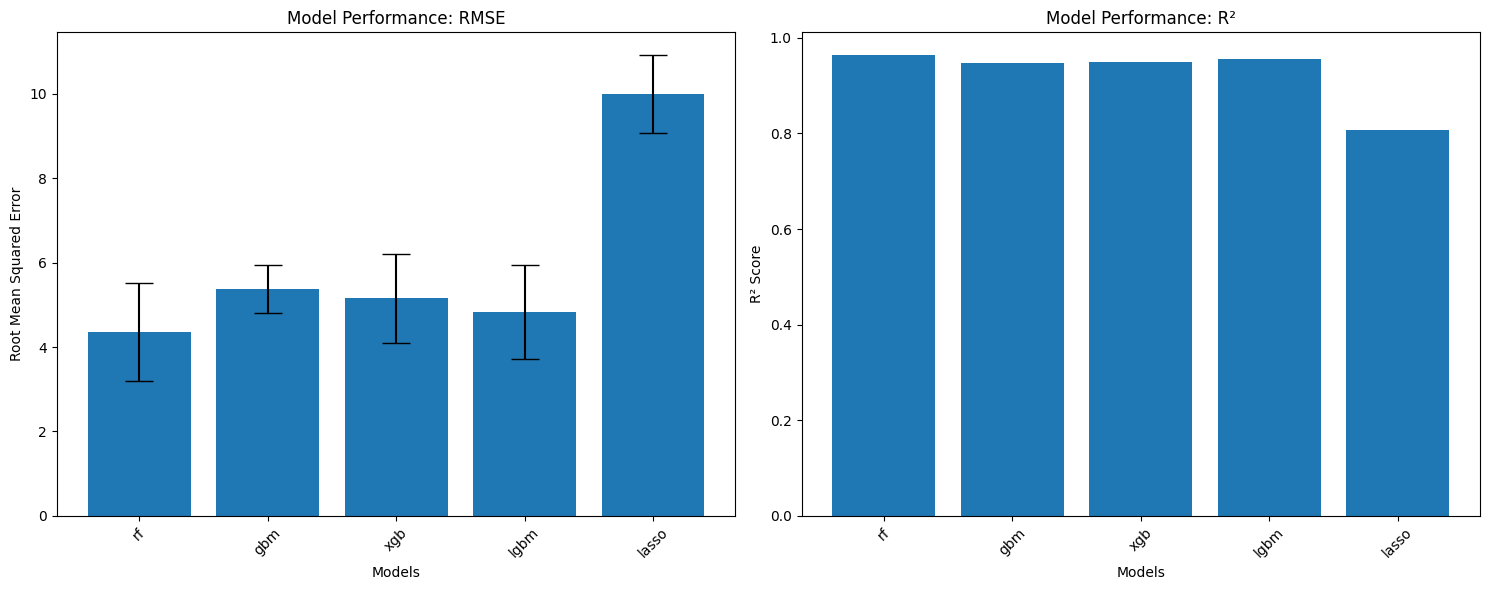

In [ ]:
# Performance Comparison Plot
plot_model_performance_comparison(model_pipeline)

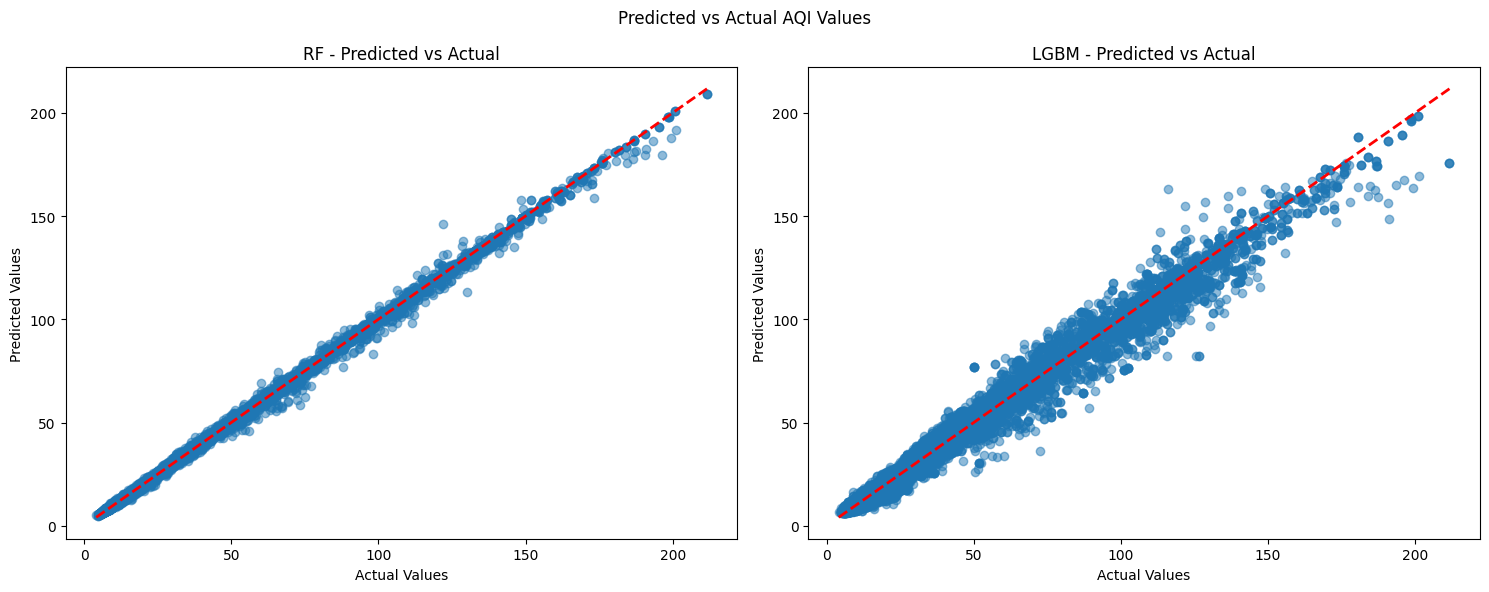

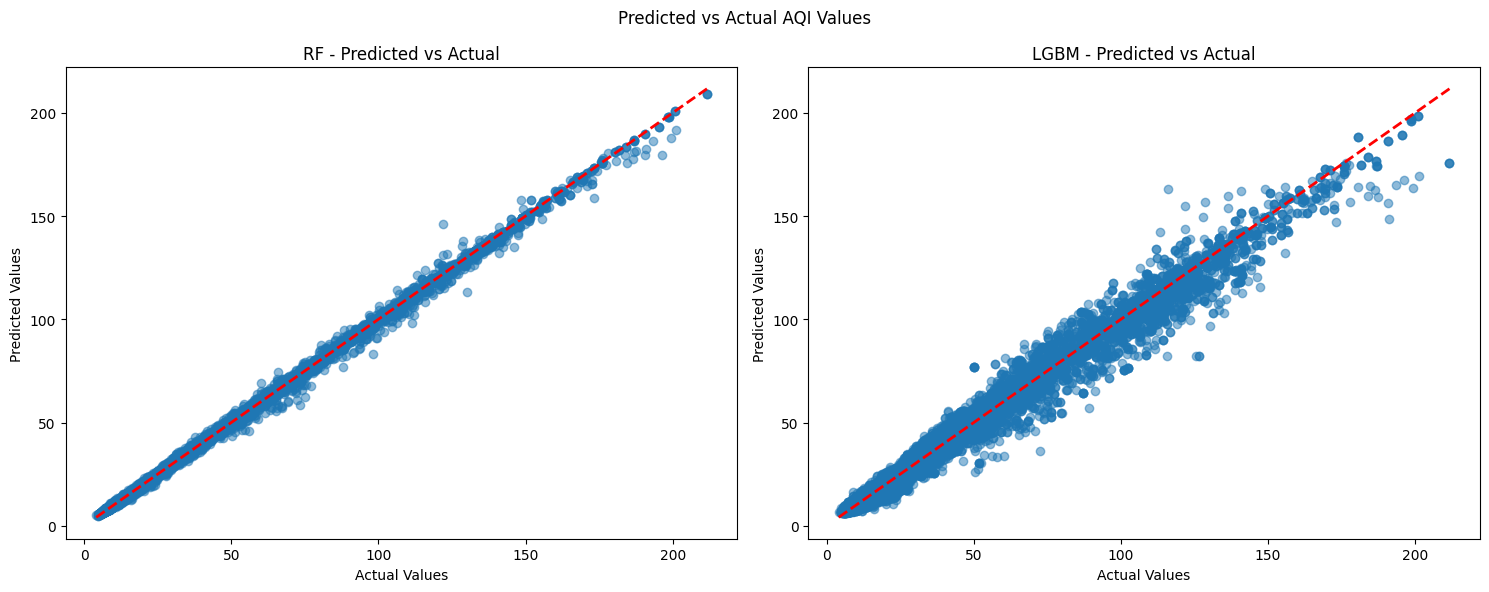

In [ ]:
# Predicted vs Actual AQI Values
plot_predicted_vs_actual(model_pipeline, X, y)

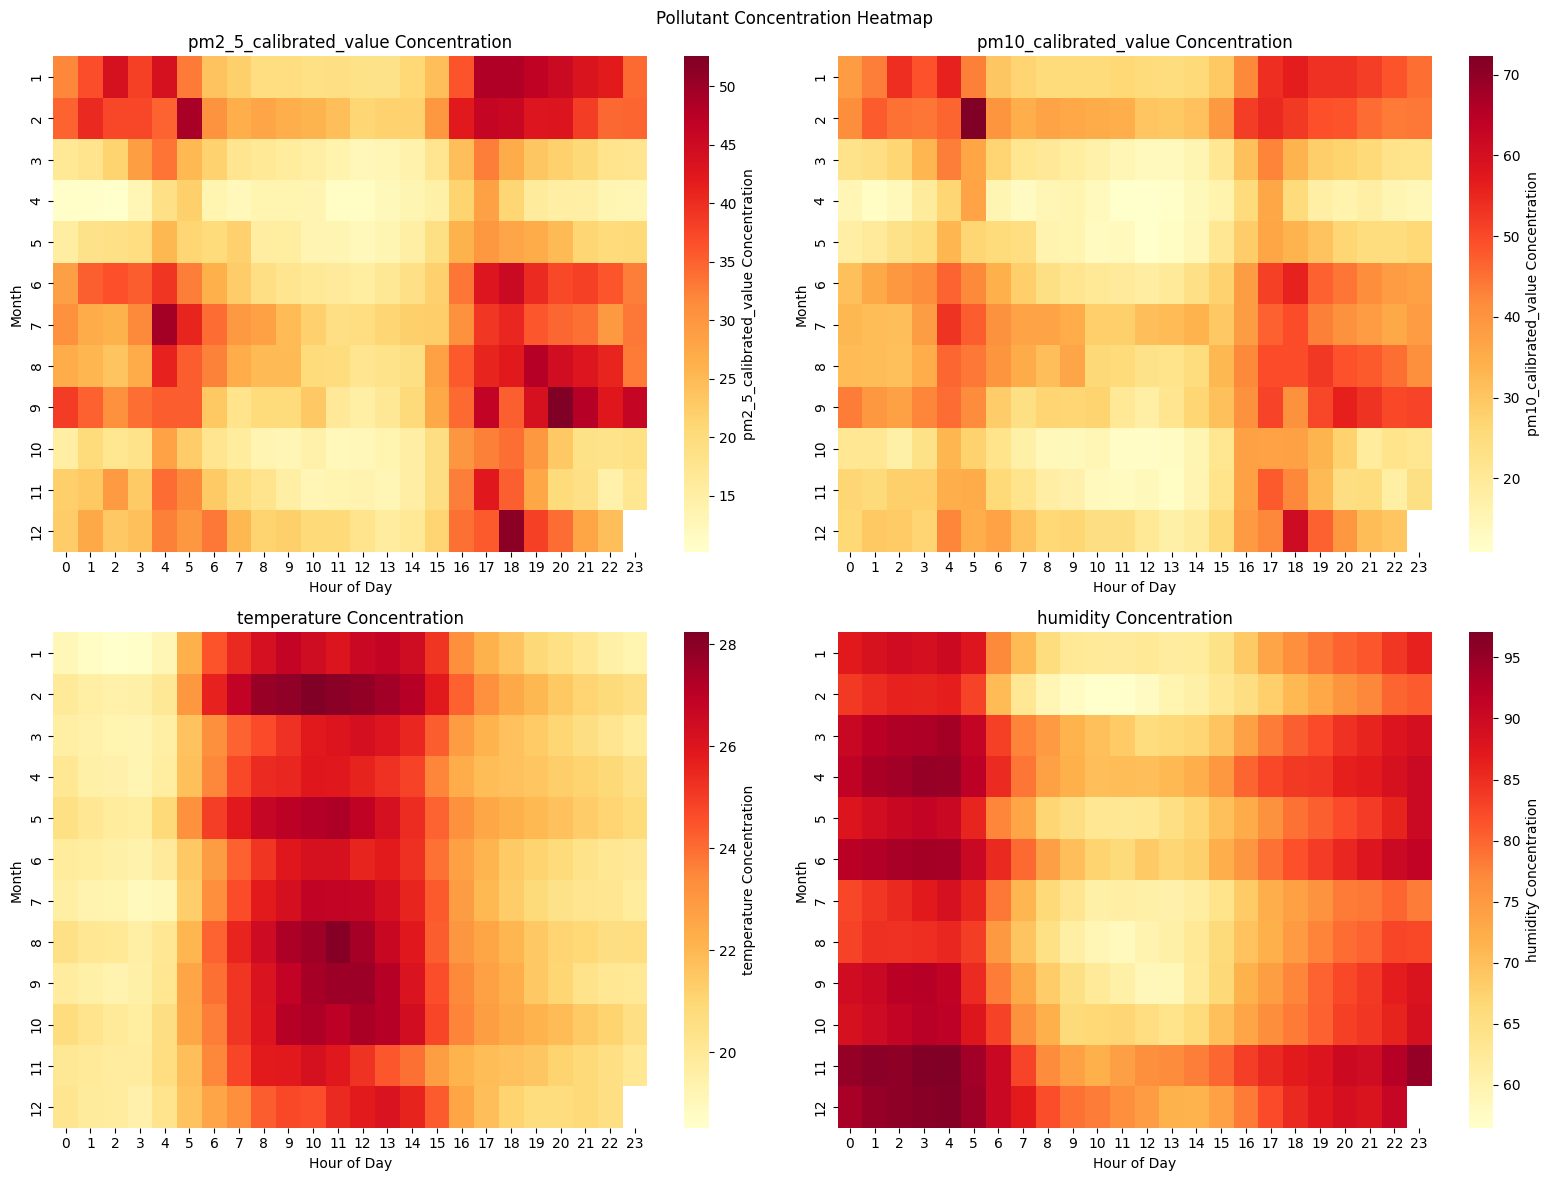

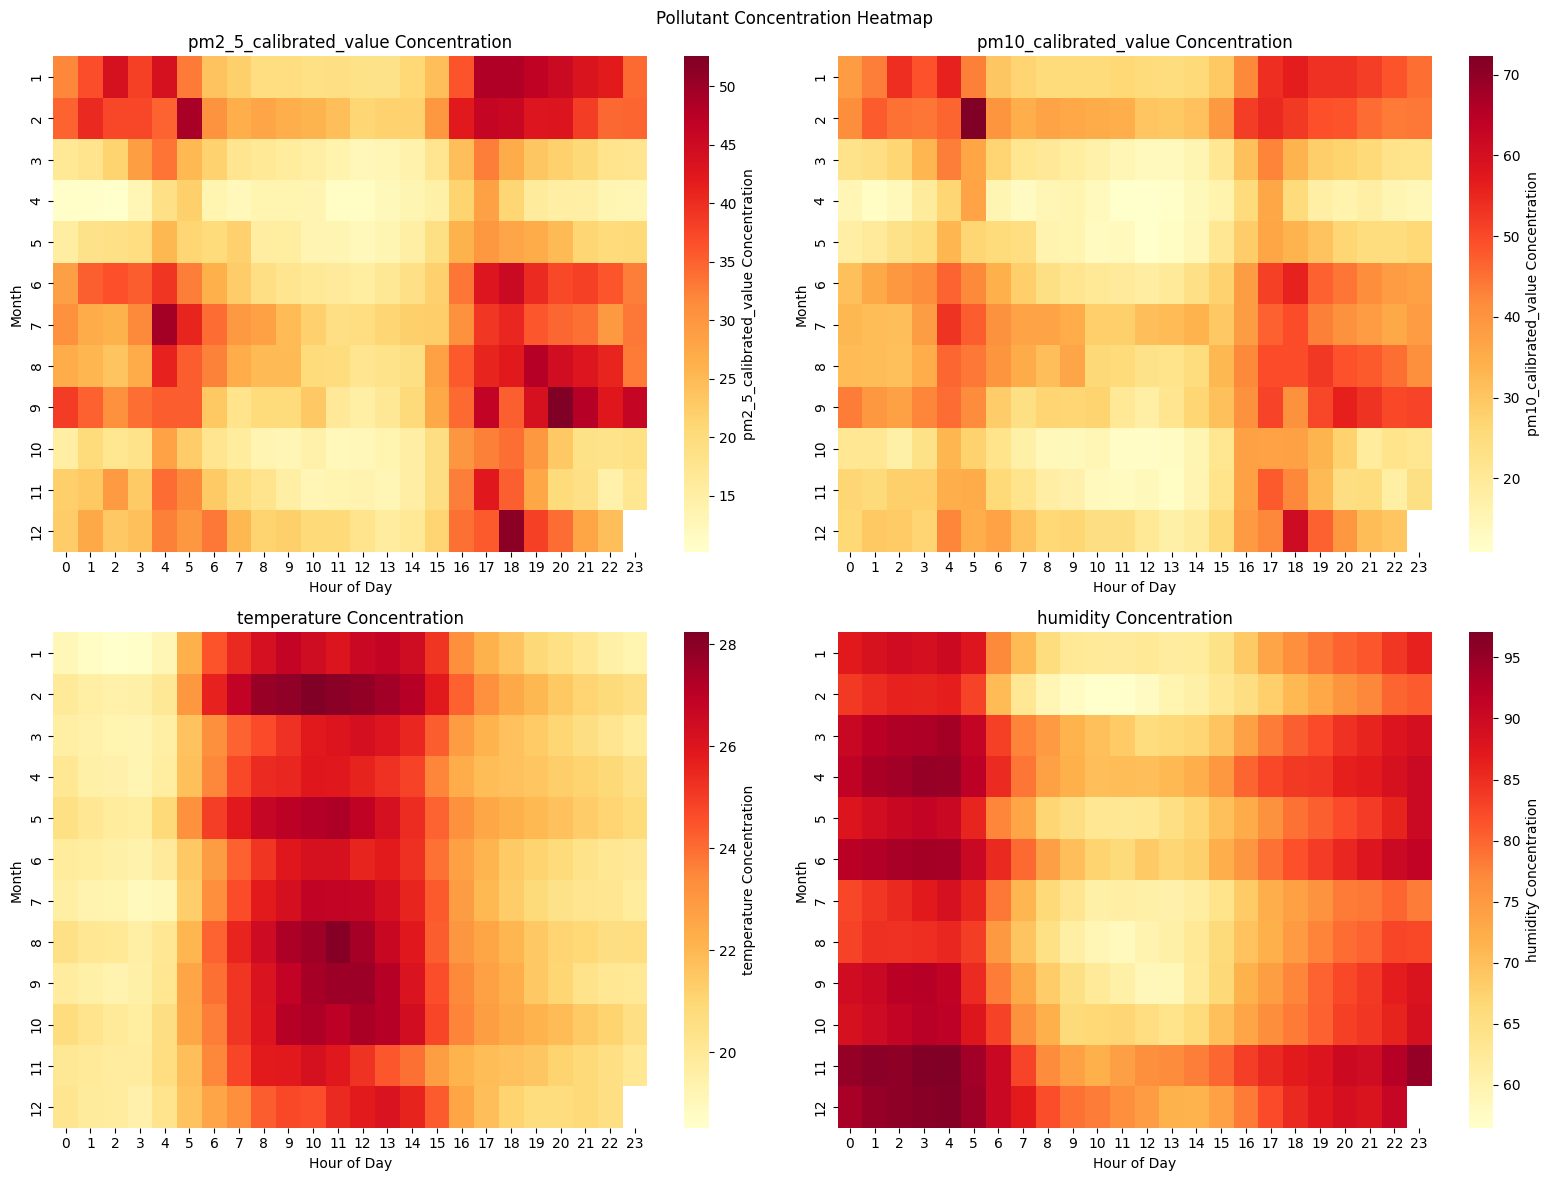

In [ ]:
# Pollutant Concentration Heatmap
plot_pollutant_concentration_heatmap(full_dataset)

### 4.3 Predicted vs. Actual AQI Values
Scatter plots comparing predicted and actual AQI values demonstrated high consistency, particularly for Random Forest and XGBoost.

In [ ]:
# Generate predicted vs actual scatter plot
# model_pipeline.plot_predicted_vs_actual()

### 4.4 Pollutant Concentration Analysis
A temporal heatmap of pollutant concentrations highlighted seasonal and diurnal variations, providing additional context for AQI fluctuations.

In [ ]:
# Generate heatmap for pollutant concentrations
# model_pipeline.plot_pollutant_heatmap()